**Imports**

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

In [ ]:
tumor = []
healthy = []
for f in glob.iglob('/content/drive/MyDrive/brain_tumor_dataset/yes/*.jpg'):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob('/content/drive/MyDrive/brain_tumor_dataset/no/*.jpg'):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [ ]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [ ]:
healthy.shape

(85, 128, 128, 3)

In [ ]:
tumor.shape

(86, 128, 128, 3)

In [ ]:
np.random.choice(10, 5, replace=False)

array([7, 0, 9, 8, 6])

In [ ]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

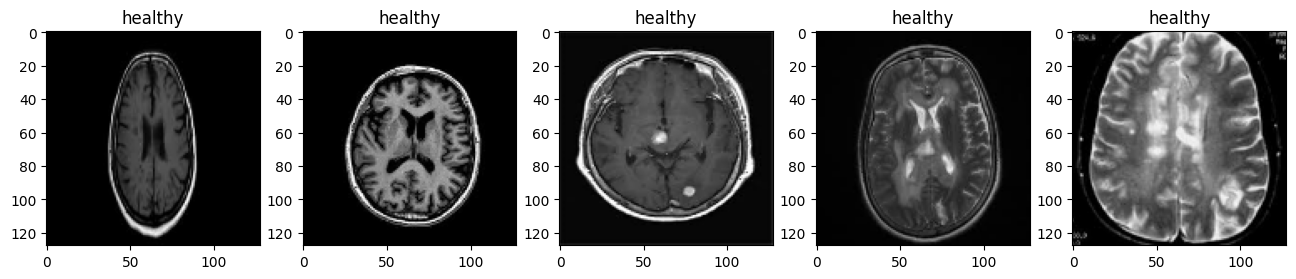

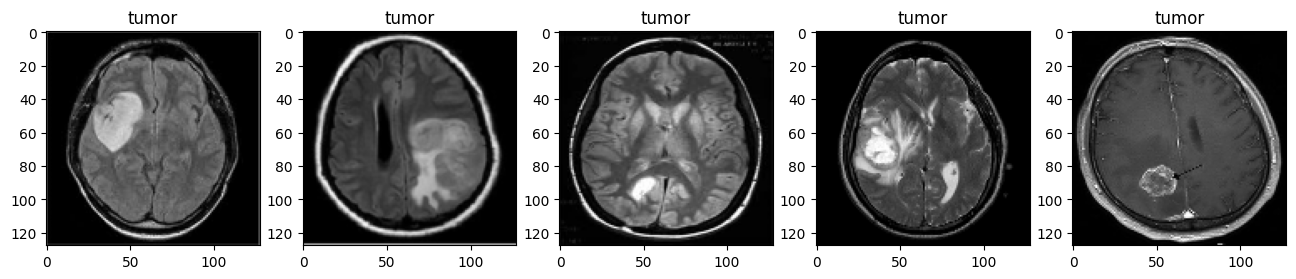

In [ ]:
plot_random(healthy, tumor, num=5)

**Dataset Class**

In [ ]:
class Dataset(object):
  def __getitem__(self, index):
    raise NotImplementedError

  def __len__(self):
    raise NotImplementedError

  def __add__(self, other):
    return ConcatDataset([self, other])

In [ ]:
#custom dataset class
class MRI(Dataset):
  def __init__(self):

    tumor = []
    healthy = []

    #load tumor positive dataset and normalize
    for file in glob.iglob('/content/drive/MyDrive/brain_tumor_dataset/yes/*.jpg'):
      img = cv2.imread(file)
      img = cv2.resize(img, (128, 128))
      b, g, r = cv2.split(img)
      img = cv2.merge([r, g, b])
      img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
      tumor.append(img)

    #load tumor negative dataset and normalize
    for file in glob.iglob('/content/drive/MyDrive/brain_tumor_dataset/no/*.jpg'):
      img = cv2.imread(file)
      img = cv2.resize(img, (128, 128))
      b, g, r = cv2.split(img)
      img = cv2.merge([r, g, b])
      img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
      healthy.append(img)

    #load images into arrays
    tumor = np.array(tumor,dtype=np.float32)
    healthy = np.array(healthy,dtype=np.float32)

    #load labels into arrays
    tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
    healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

    #concatenates
    self.images = np.concatenate((tumor, healthy), axis=0)
    self.labels = np.concatenate((tumor_label, healthy_label))

  def __len__(self):
    return self.images.shape[0]

  def __getitem__(self, index):
    sample = {'image': self.images[index], 'label': self.labels[index]}
    return sample

  def normalize(self):
    self.images = self.images/255.0

In [ ]:
mri_dataset = MRI()
mri_dataset.normalize()

**Dataloader**

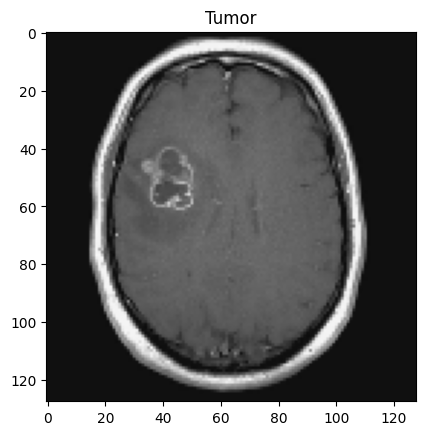

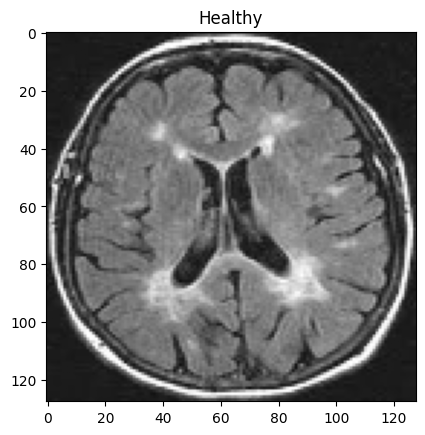

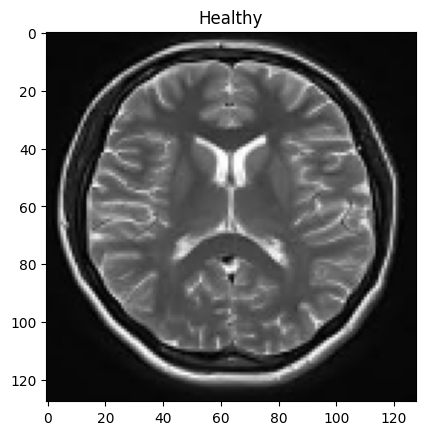

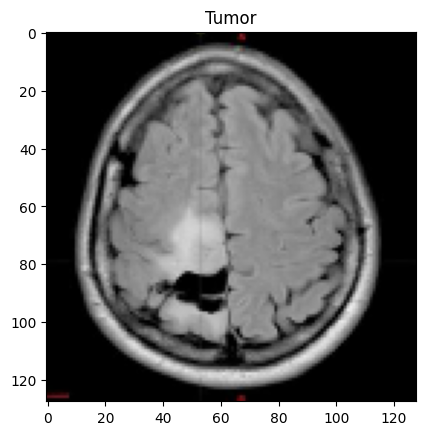

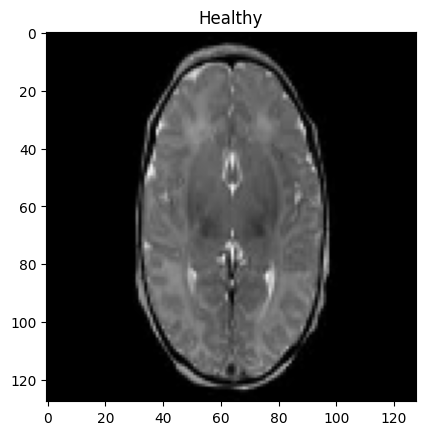

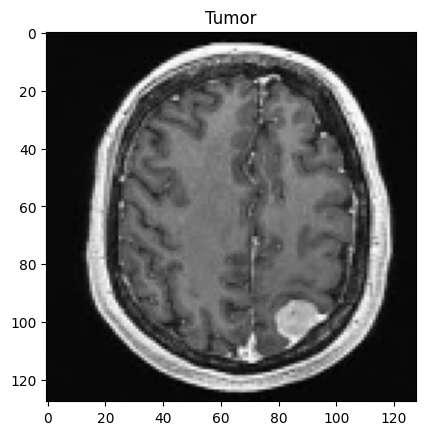

In [ ]:
names = {0:'Healthy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
  img = sample['image'].squeeze()
  img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
  plt.title(names[sample['label'].item()])
  plt.imshow(img)
  plt.show()
  if i == 5:
    break

**CNN Model**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5)
        )

    self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1)
    )

  def forward(self, x):
    x = self.cnn_model(x)
    x = x.view(x.size(0), -1)
    x = self.fc_model(x)
    x = F.sigmoid(x)

    return x

In [ ]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda:0')
model = CNN().to(device)

In [ ]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [ ]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

model_save_path = '/content/drive/MyDrive/model_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Train Epoch: 10	Loss: 0.678418
Train Epoch: 20	Loss: 0.629321
Train Epoch: 30	Loss: 0.556366
Train Epoch: 40	Loss: 0.523366
Train Epoch: 50	Loss: 0.494523
Train Epoch: 60	Loss: 0.489940
Train Epoch: 70	Loss: 0.437223
Train Epoch: 80	Loss: 0.415822
Train Epoch: 90	Loss: 0.378915
Train Epoch: 100	Loss: 0.355285
Train Epoch: 110	Loss: 0.336171
Train Epoch: 120	Loss: 0.280292
Train Epoch: 130	Loss: 0.273583
Train Epoch: 140	Loss: 0.259924
Train Epoch: 150	Loss: 0.235955
Train Epoch: 160	Loss: 0.197688
Train Epoch: 170	Loss: 0.195876
Train Epoch: 180	Loss: 0.159791
Train Epoch: 190	Loss: 0.161642
Train Epoch: 200	Loss: 0.128999
Train Epoch: 210	Loss: 0.104467
Train Epoch: 220	Loss: 0.079935
Train Epoch: 230	Loss: 0.066524
Train Epoch: 240	Loss: 0.056442
Train Epoch: 250	Loss: 0.041716
Train Epoch: 260	Loss: 0.038972
Train Epoch: 270	Loss: 0.028820
Train Epoch: 280	Loss: 0.023776
Train Epoch: 290	Loss: 0.017903
Train Epoch: 300	Loss: 0.015427
Train Epoch: 310	Loss: 0.011231
Train Epoch: 320	

In [ ]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [ ]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [ ]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

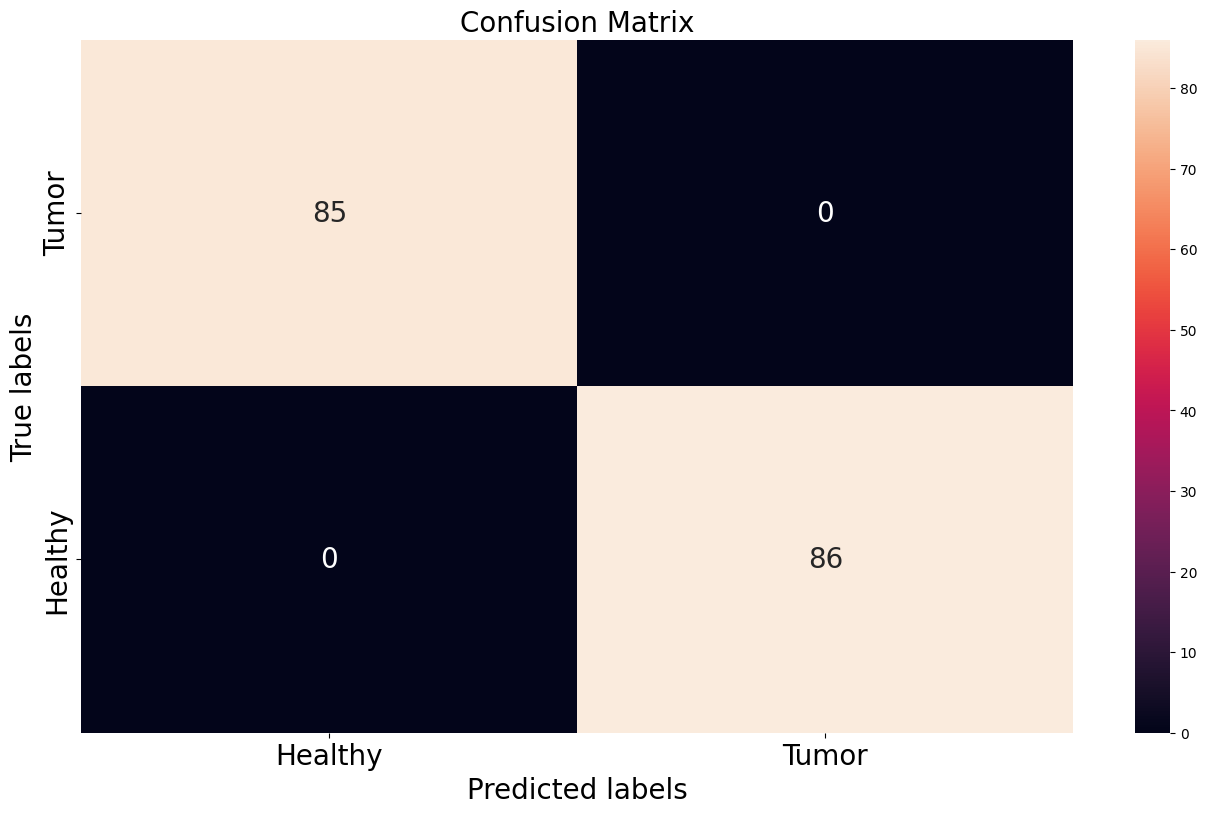

In [ ]:
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

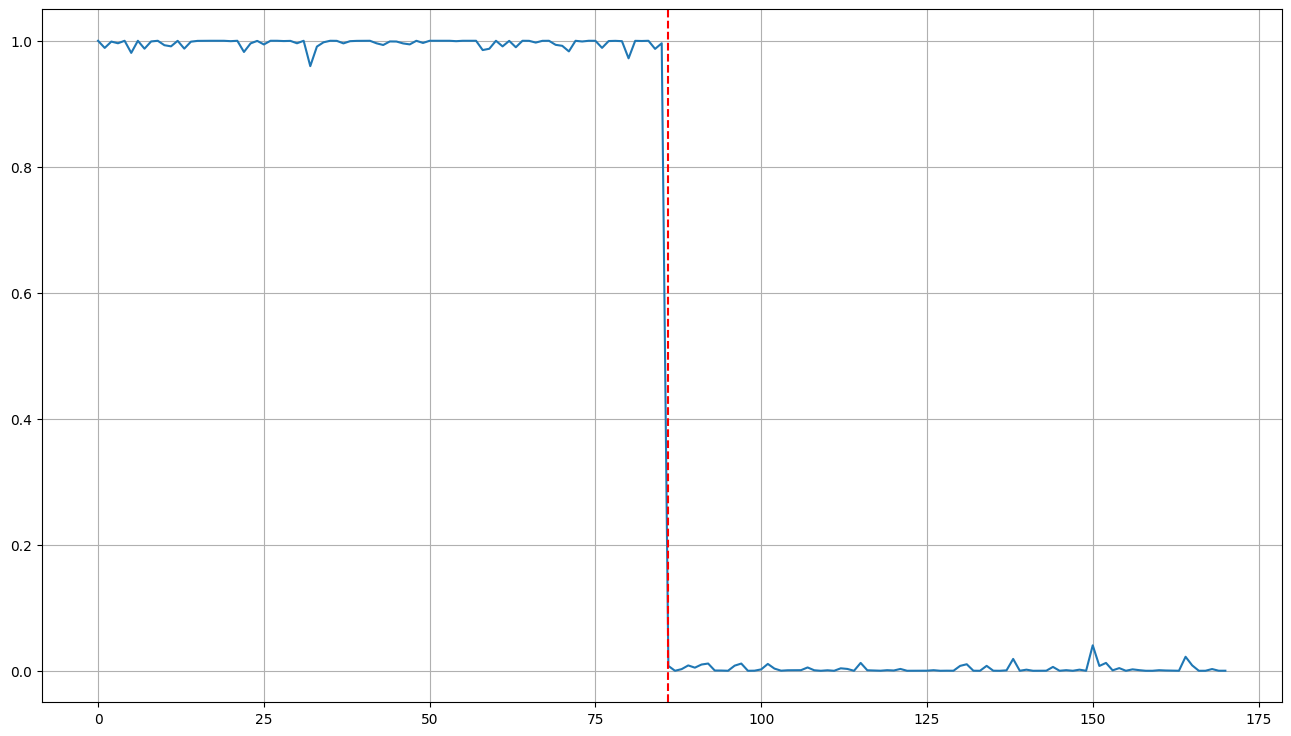

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [ ]:
from google.colab import files

def preprocess_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    img = img.transpose((2, 0, 1))
    img = img / 255.0
    return torch.tensor(img, dtype=torch.float32).unsqueeze(0)

model.load_state_dict(torch.load('/content/drive/MyDrive/model_model.pth', map_location=device))
model.eval()

uploaded = files.upload()

for file_name in uploaded.keys():
    print(f"Processing uploaded file: {file_name}")
    image_tensor = preprocess_image(file_name).to(device)

    with torch.no_grad():
        output = model(image_tensor).item()

    if output >= 0.5:
        print("Tumor")
    else:
        print("Healthy")

<ipython-input-200-4674e5d5a151>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/model_model.pth', map_location=de

Saving tumor2.JPG to tumor2.JPG
Processing uploaded file: tumor2.JPG
Healthy
